# Size a GPU Cluster With NVIDIA NeMo Agent Toolkit

This notebook demonstrates how to use the NVIDIA NeMo Agent toolkit's sizing calculator to estimate the GPU cluster size required to accommodate a target number of users with a target response time. The estimation is based on the performance of the workflow at different concurrency levels.

The sizing calculator uses the [evaluation](https://docs.nvidia.com/nemo/agent-toolkit/latest/workflows/evaluate.html) and [profiling](https://docs.nvidia.com/nemo/agent-toolkit/latest/workflows/profiler.html) systems in the NeMo Agent toolkit.

**Note:** This guide assumes that you have an LLM hosted by an isolated GPU cluster, for which you want to perform the sizing calculations. Although you can run the sizing calculator against a publicly hosted LLM, the results may not be accurate due to the variability in the performance of public LLMs.


## Setup: Import Python Packages

In [ ]:
# SPDX-FileCopyrightText: Copyright (c) 2025, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import getpass
import os
import shutil
import site
import subprocess
import sys

import yaml

## Setup: Install ``uv`` and Git LFS

This environment will be managed by ``uv``. First, we can go ahead and install it on this system and add it to ``$PATH``. We can also install Git LFS to ensure submodules are properly populated upon cloning the NeMo Agent Toolkit repository. 

In [ ]:
# Install uv
!curl -LsSf https://astral.sh/uv/install.sh | sh
os.environ["PATH"]=f"/home/ubuntu/.local/bin:{os.environ['PATH']}"

# Install Git LFS
!sudo apt-get install git-lfs

## Setup: Clone the NeMo Agent Toolkit Repository

First, let's clone the NVIDIA NeMo Agent Toolkit repository to get access to all the necessary files and examples.


In [ ]:
# Check if the repository already exists
repo_name = "NeMo-Agent-Toolkit"
if not os.path.exists(repo_name):
    print("Cloning NVIDIA NeMo Agent Toolkit repository...")
    subprocess.run(["git", "clone", "https://github.com/NVIDIA/NeMo-Agent-Toolkit.git"], check=True)
    print("Repository cloned successfully!")
else:
    print(f"Repository {repo_name} already exists.")

# Change to the repository directory
os.chdir(repo_name)
print(f"Changed to directory: {os.getcwd()}")

## Initialize Git Submodules and LFS

The NeMo Agent Toolkit uses Git submodules and Large File Storage (LFS) for some components.


In [ ]:
# Initialize, fetch, and update submodules
print("Initializing Git submodules...")
subprocess.run(["git", "submodule", "update", "--init", "--recursive"], check=True)

# Fetch LFS files
print("Setting up Git LFS...")
subprocess.run(["git", "lfs", "install"], check=True)
subprocess.run(["git", "lfs", "fetch"], check=True)
subprocess.run(["git", "lfs", "pull"], check=True)

print("Git setup completed!")

## Install Dependencies

We'll install the NeMo Agent Toolkit and its dependencies using `uv` (or `pip` as a fallback).


In [ ]:
# Check if uv is available, otherwise use pip
if shutil.which("uv"):
    print("Installing NeMo Agent Toolkit using uv...")

    # Create virtual environment with uv (specifying Python 3.12 as recommended)
    subprocess.run(["uv", "venv", "--python", "3.12", "--seed", ".venv"], check=True)
    print("Virtual environment created successfully!")

    # Install all dependencies including profiling tools and plugins
    subprocess.run(["uv", "sync", "--all-groups", "--all-extras"], check=True)
    print("Installation completed with uv!")

    # Activate the virtual environment for this session
    venv_path = os.path.join(os.getcwd(), ".venv")
    if os.name == 'nt':  # Windows
        scripts_dir = os.path.join(venv_path, "Scripts")
        python_exe = os.path.join(scripts_dir, "python.exe")
    else:  # Unix/Linux/macOS
        scripts_dir = os.path.join(venv_path, "bin")
        python_exe = os.path.join(scripts_dir, "python")

    # Add virtual environment to Python path
    site_pkgs = "site-packages" if os.name == 'nt' else "lib/python{}.{}/site-packages".format(*sys.version_info[:2])
    site.addsitedir(os.path.join(venv_path, "Lib", site_pkgs))

    # Update PATH to include the virtual environment's Scripts bin directory
    current_path = os.environ.get('PATH', '')
    os.environ['PATH'] = scripts_dir + os.pathsep + current_path

    print(f"Virtual environment activated! Scripts directory: {scripts_dir}")

else:
    print("uv not found, using pip instead...")
    print("Note: uv is recommended for proper installation. Please install uv for best results.")
    # Install using pip
    subprocess.run([sys.executable, "-m", "pip", "install", "-e", ".[profiling]"], check=True)
    print("Installation completed with pip!")

## Verify Installation

Let's verify that the NeMo Agent Toolkit is properly installed.


In [ ]:
# Verify installation
print("Checking installation...")
print(f"Current working directory: {os.getcwd()}")
print(f"Python executable: {sys.executable}")
print(f"PATH: {os.environ.get('PATH', '')[:200]}...")  # Show first 200 chars of PATH

# Check if nat command is available
nat_path = shutil.which("nat")
if nat_path:
    print(f"nat command found at: {nat_path}")
else:
    print("nat command not found in PATH")

    # Check if it exists in the virtual environment
    venv_path = os.path.join(os.getcwd(), ".venv")
    if os.name == 'nt':  # Windows
        potential_nat = os.path.join(venv_path, "Scripts", "nat.exe")
    else:  # Unix/Linux/macOS
        potential_nat = os.path.join(venv_path, "bin", "nat")

    if os.path.exists(potential_nat):
        print(f"nat found in virtual environment at: {potential_nat}")
        print("The virtual environment may not be properly activated.")
    else:
        print(f"nat not found at expected location: {potential_nat}")

# Try to run nat command
try:
    result = subprocess.run(["nat", "--version"], capture_output=True, text=True, check=True)
    print(f"✅ NeMo Agent Toolkit version: {result.stdout.strip()}")
    print("✅ Installation verified successfully!")
except subprocess.CalledProcessError as e:
    print(f"❌ Error running nat --version: {e}")
    print(f"Return code: {e.returncode}")
    if e.stderr:
        print(f"Error output: {e.stderr}")
except FileNotFoundError as e:
    print(f"❌ nat command not found: {e}")
    print("\nTroubleshooting steps:")
    print("1. Make sure uv is installed: pip install uv")
    print("2. Re-run the installation cell above")
    print("3. Check that the virtual environment was created successfully")
    print("4. Manually activate the virtual environment if needed:")
    if os.name == 'nt':
        print("   .venv\\Scripts\\activate")
    else:
        print("   source .venv/bin/activate")

In [ ]:
# Helper function to run nat commands with proper environment
def run_nat_command(args, **kwargs):
    """
    Run nat command with proper virtual environment activation.
    This ensures the command works even if the notebook environment isn't fully activated.
    """
    venv_path = os.path.join(os.getcwd(), ".venv")

    if os.name == 'nt':  # Windows
        nat_executable = os.path.join(venv_path, "Scripts", "nat.exe")
        python_executable = os.path.join(venv_path, "Scripts", "python.exe")
    else:  # Unix/Linux/macOS
        nat_executable = os.path.join(venv_path, "bin", "nat")
        python_executable = os.path.join(venv_path, "bin", "python")

    # Try direct nat executable first
    if os.path.exists(nat_executable):
        cmd = [nat_executable] + args
        print(f"Running: {' '.join(cmd)}")
        return subprocess.run(cmd, check=False, **kwargs)

    # Fallback to python -m nat
    elif os.path.exists(python_executable):
        cmd = [python_executable, "-m", "nat"] + args
        print(f"Running: {' '.join(cmd)}")
        return subprocess.run(cmd, check=False, **kwargs)

    # Last resort: try system nat
    else:
        cmd = ["nat"] + args
        print(f"Running: {' '.join(cmd)}")
        return subprocess.run(cmd, check=False, **kwargs)

# Test the helper function
print("Testing nat command with helper function...")
try:
    result = run_nat_command(["--version"], capture_output=True, text=True, check=True)
    print(f"✅ Success! Version: {result.stdout.strip()}")
except Exception as e:
    print(f"❌ Still having issues: {e}")
    print("The installation may need to be re-run.")

## Environment Variables

Set up the required environment variables for API access (if using NVIDIA NIMs).


In [ ]:
# Set API key in notebook environment
if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key
    print("✅ API key has been set in notebook environment")

## Deploy an LLM

Uncomment the following and run the following command to spin up a sample model on ``http://localhost:8000/v1``. 

Alternatively, you can use a model running elsewhere, just remember to input that model location as the ``base_url`` in the below model configurations section. 

In [ ]:
# !echo "${NVIDIA_API_KEY}" | docker login nvcr.io -u '$oauthtoken' --password-stdin
# !docker run -it -d --rm \
#   --name local-nim \
#   --runtime=nvidia \
#   --gpus '"device=0,1"' \
#   -p 8000:8000 \
#   -v "/tmp:/opt/nim/.cache" \
#   -e NGC_API_KEY="${NVIDIA_API_KEY}" \
#   --shm-size=20g \
#   nvcr.io/nim/meta/llama-3.1-70b-instruct:latest

In [ ]:
# View container status - look for 'uvicorn running on http://0.0.0.0:8000'
# !docker logs local-nim

## Configuration Setup

To begin, set the configuration file and output directory. For this example we will start with the simple calculator evaluation configuration file, however in a real-world scenario you would use the configuration file of your own workflow you want to size.

### Dataset Considerations

When using the sizing calculator, you need a representative dataset of inputs. The size of the dataset can be as small as one input. However, if your workflow's behavior varies significantly depending on the input, we recommend including representative dataset entries for each trajectory.

The dataset is provided in the eval section of the workflow configuration file.
`examples/evaluation_and_profiling/simple_calculator_eval/configs/config-sizing-calc.yml`:
```yaml
eval:
  general:
    output_dir: .tmp/nat/examples/simple_calculator/eval
    dataset:
      _type: json
      file_path: examples/getting_started/simple_calculator/data/simple_calculator.json
```

In addition to the dataset, you need to specify the `eval.general.output_dir` parameter for storing the evaluation results. Other parameters in the eval section are not used by the calculator. For more information, refer to the [Evaluate](../docs/source/reference/evaluate.md) documentation.

The dataset used by the sizing calculator does not need to include ground truth answers. Only the inputs are needed.
For example, the following dataset is valid:
```json
[
    {
        "id": 1,
        "question": "What is the product of 3 and 7, and is it greater than the current hour?",
    },
    {
        "id": 2,
        "question": "What is the product of 4 and 5, and is it greater than the current hour?",
    }
]
```

### Adjust the Model Configuration

Finally, you will need to edit the configuration file to point to your LLM cluster. Make sure your LLM(s) are up and running and reachable! 

The configuration should include a `base_url` parameter for your cluster. You can edit the file manually yourself, or use the below interactive configuration editor.

<div class="alert alert-block alert-success">
    <b>NOTE:</b> You can bring your own config file! Simply replace <b>source_config</b> below with a path to your uploaded config file in the <b>NeMo-Agent-Toolkit</b> repo. 
</div>

In [ ]:
source_config = "examples/evaluation_and_profiling/simple_calculator_eval/configs/config-sizing-calc.yml"

# Display the current configuration file (if it exists)
if os.path.exists(source_config):
    print("Current configuration file content:")
    print("=" * 50)
    with open(source_config, 'r') as f:
        config_content = f.read()
        print(config_content)
    print("=" * 50)
    print("\nPlease edit this file to add your LLM cluster details.")
    print("Example for a locally hosted NIM:")
    print("""
llms:
  nim_llm:
    _type: nim
    base_url: "http://localhost:8000/v1"
    model_name: meta/llama-3.1-70b-instruct
    """)

    # Interactive configuration editor
    print("\n" + "="*60)
    print("INTERACTIVE CONFIGURATION EDITOR")
    print("="*60)

    modify_config = input("Would you like to modify the configuration interactively? (y/n): ").lower().strip()

    if modify_config == 'y':
        base_url = input("Enter your LLM base URL (e.g., http://localhost:8000/v1): ").strip()
        model_name = input("Enter your model name (e.g., meta/llama-3.1-70b-instruct): ").strip()

        if base_url and model_name:
            # Simple configuration update
            try:
                config_data = yaml.safe_load(config_content)
                if 'llms' not in config_data:
                    config_data['llms'] = {}
                if 'nim_llm' not in config_data['llms']:
                    config_data['llms']['nim_llm'] = {}

                config_data['llms']['nim_llm']['_type'] = 'nim'
                config_data['llms']['nim_llm']['base_url'] = base_url
                config_data['llms']['nim_llm']['model_name'] = model_name

                print("\nUpdated configuration:")
                print(yaml.dump(config_data, default_flow_style=False))

                save_config = input("Save this configuration? (y/n): ").lower().strip()
                if save_config == 'y':
                    with open(source_config, 'w') as f:
                        yaml.dump(config_data, f, default_flow_style=False)
                    print("✅ Configuration saved!")
                else:
                    print("Configuration not saved.")

            except Exception as e:
                print(f"Error parsing YAML: {e}")
                print("Please edit the file manually.")
        else:
            print("Base URL and model name are required. Please edit manually.")
    else:
        print("Please edit the configuration file manually before proceeding.")

else:
    print("Configuration file not found. Please create one manually.")

In [ ]:
# Set up environment variables and directories
calc_output_dir = "results/sizing_calc/"
config_file = os.path.join(calc_output_dir, "config-sizing-calc.yml")

# Create output directory
os.makedirs(calc_output_dir, exist_ok=True)

# Copy the example configuration file
if os.path.exists(source_config):
    shutil.copy(source_config, config_file)
    print(f"Configuration file copied to: {config_file}")
else:
    print(f"Warning: Source configuration file not found at {source_config}")
    print("You may need to create a custom configuration file.")

print(f"Output directory: {calc_output_dir}")
print(f"Config file: {config_file}")


## Step 1: Gather Metrics

Collect performance data at different concurrency levels. This step runs the workflow at specified concurrency levels to gather performance metrics.

To use the calculator, gather metrics from the workflow and then separately size the cluster in `offline_mode` using the previously gathered metrics.

The following is a sample command for gathering metrics:

```
nat sizing calc --config_file $CONFIG_FILE --calc_output_dir $CALC_OUTPUT_DIR --concurrencies 1,2,4,8,16,32 --num_passes 2
```

### Specifying the Concurrency Range
A slope based mechanism is used to estimate the GPU count required for the workflow. To create a robust linear fit, we recommend using a wide range of concurrency values. A minimum of ten concurrency values is recommended, though the calculator can work with fewer values (accuracy may decrease). The concurrency range is specified as a comma separated list with the `--concurrencies` command line parameter.

In addition to the concurrency range, you can specify the number of passes made with each concurrency with the `--num_passes` command line parameter. By default the number of passes is one or a multiple of the concurrency if the dataset is larger than the concurrency value.

If the size of the dataset is smaller than the concurrency range specified, the dataset is repeated to match the concurrency range.

**Note:** Depending on the number of concurrencies, the number of passes, and the size of the cluster being tested, this could take several minutes to run.

In [ ]:
# Define parameters for metric gathering
concurrencies = "1,2,4,8,16,32"
num_passes = 2

# Build the command
gather_metrics_cmd = [
    "nat", "sizing", "calc",
    "--config_file", config_file,
    "--calc_output_dir", calc_output_dir,
    "--concurrencies", concurrencies,
    "--num_passes", str(num_passes)
]

try:
    result = subprocess.run(gather_metrics_cmd, check=True, capture_output=True, text=True)
    print("Metrics gathering completed successfully!")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print(f"Error running sizing calculator: {e}\n")
    print(f"Error output: {e.stderr}\n")


In [ ]:
# Helper functions to display the generated plots

import os

import matplotlib.pyplot as plt
from PIL import Image


def display_online_simple():
    root_folder = "results/sizing_calc/online"
    filename = "concurrency_vs_p95_simple.png"

    # Find all matching images
    image_paths = []

    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):  # Only check directories
            image_path = os.path.join(folder_path, filename)
            if os.path.isfile(image_path):
                image_paths.append(image_path)

    # Display all found images
    if not image_paths:
        print("No images found!")
        return

    print(f"Found {len(image_paths)} images:")
    for i, img_path in enumerate(image_paths):
        print(f"  {i+1}. {img_path}")

        # Display the image
        img = Image.open(img_path)
        plt.figure(figsize=(15, 9))
        plt.imshow(img)
        plt.title(f"Image {i+1}: {os.path.basename(os.path.dirname(img_path))}")
        plt.axis('off')
        plt.show()

def display_online_analysis():
    root_folder = "results/sizing_calc/online"
    filename = "concurrency_vs_p95_analysis.png"

    # Find all matching images
    image_paths = []

    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):  # Only check directories
            image_path = os.path.join(folder_path, filename)
            if os.path.isfile(image_path):
                image_paths.append(image_path)

    # Display all found images
    if not image_paths:
        print("No images found!")
        return

    print(f"Found {len(image_paths)} images:")
    for i, img_path in enumerate(image_paths):
        print(f"  {i+1}. {img_path}")

        # Display the image
        img = Image.open(img_path)
        plt.figure(figsize=(15, 9))
        plt.imshow(img)
        plt.title(f"Image {i+1}: {os.path.basename(os.path.dirname(img_path))}")
        plt.axis('off')
        plt.show()

def display_offline_simple():
    root_folder = "results/sizing_calc/offline"
    filename = "concurrency_vs_p95_simple.png"

    # Find all matching images
    image_paths = []

    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):  # Only check directories
            image_path = os.path.join(folder_path, filename)
            if os.path.isfile(image_path):
                image_paths.append(image_path)

    # Display all found images
    if not image_paths:
        print("No images found!")
        return

    print(f"Found {len(image_paths)} images:")
    for i, img_path in enumerate(image_paths):
        print(f"  {i+1}. {img_path}")

        # Display the image
        img = Image.open(img_path)
        plt.figure(figsize=(15, 9))
        plt.imshow(img)
        plt.title(f"Image {i+1}: {os.path.basename(os.path.dirname(img_path))}")
        plt.axis('off')
        plt.show()

def display_offline_analysis():
    root_folder = "results/sizing_calc/offline"
    filename = "concurrency_vs_p95_analysis.png"

    # Find all matching images
    image_paths = []

    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):  # Only check directories
            image_path = os.path.join(folder_path, filename)
            if os.path.isfile(image_path):
                image_paths.append(image_path)

    # Display all found images
    if not image_paths:
        print("No images found!")
        return

    print(f"Found {len(image_paths)} images:")
    for i, img_path in enumerate(image_paths):
        print(f"  {i+1}. {img_path}")

        # Display the image
        img = Image.open(img_path)
        plt.figure(figsize=(15, 9))
        plt.imshow(img)
        plt.title(f"Image {i+1}: {os.path.basename(os.path.dirname(img_path))}")
        plt.axis('off')
        plt.show()

In [ ]:
display_online_simple()

In [ ]:
display_online_analysis()

## Step 2: Estimate GPU Cluster Size

Once the metrics are gathered, you can estimate the GPU cluster size using the `nat sizing calc` command in `offline_mode`.
Sample command:
```
nat sizing calc --offline_mode --calc_output_dir $CALC_OUTPUT_DIR --test_gpu_count 8 --target_workflow_runtime 10 --target_users 100
```

### Target and Test Parameters
**Target Parameters**

To estimate the GPU cluster size, you need to specify the target number of users and the target workflow runtime, that is the maximum acceptable response time for the workflow.

Optionally, you can specify the target p95 LLM latency if the LLM latency is a defining factor for the workflow and if it is possible to measure the maximum acceptable LLM latency.
- `target_users`: Target number of users to support.
- `target_workflow_runtime`: Target p95 workflow runtime (seconds). Can be set to 0 to ignore.
- `target_llm_latency`: Target p95 LLM latency (seconds). Can be set to 0 to ignore.

**Test Parameters**

You need to specify the number of GPUs used for running the workflow via the `--test_gpu_count` command line parameter. This is the number of GPUs used during the profiling run, not the target cluster size. This information is used to extrapolate the GPU count required for the target users.

In [ ]:
# Define target parameters
test_gpu_count = 8  # Number of GPUs used during testing
target_workflow_runtime = 10  # Target response time in seconds
target_users = 100  # Target number of concurrent users

# Build the estimation command
estimate_cmd = [
    "nat", "sizing", "calc",
    "--offline_mode",
    "--calc_output_dir", calc_output_dir,
    "--test_gpu_count", str(test_gpu_count),
    "--target_workflow_runtime", str(target_workflow_runtime),
    "--target_users", str(target_users)
]

try:
    result = subprocess.run(estimate_cmd, check=True, capture_output=True, text=True)
    print("GPU cluster sizing completed successfully!")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print(f"Error running GPU estimation: {e}\n")
    print(f"Error output: {e.stderr}\n")


In [ ]:
display_offline_simple()

In [ ]:
display_offline_analysis()

## Combined Approach (Alternative)

You can also combine both steps into a single command by adding the target and test parameters to the first command.

**Note:** Depending on the number of concurrencies, the number of passes, and the size of the cluster being tested, this could take several minutes to run.


In [ ]:
# Uncomment to run combined command that gathers metrics and estimates GPU count

# combined_cmd = [
#     "nat", "sizing", "calc",
#     "--config_file", config_file,
#     "--calc_output_dir", calc_output_dir,
#     "--concurrencies", concurrencies,
#     "--num_passes", str(num_passes),
#     "--test_gpu_count", str(test_gpu_count),
#     "--target_workflow_runtime", str(target_workflow_runtime),
#     "--target_users", str(target_users)
# ]

# try:
#     result = subprocess.run(combined_cmd, check=True, capture_output=True, text=True)
#     print("Combined sizing operation completed successfully!")
#     print(result.stdout)
# except subprocess.CalledProcessError as e:
#     print(f"Error running combined sizing: {e}\n")
#     print(f"Error output: {e.stderr}\n")


## Understanding the Outputs

The per-concurrency metrics are stored in the `calc_output_dir` specified in the command line. We recommend using a separate output directory for the calculator than the one used for the evaluation (specified through `eval.general.output_dir` in the workflow configuration file). This avoids accidental deletion of the calculator metrics when the evaluation jobs cleans up.

By default, the metrics of the latest calculator run overwrite the previous runs. You can use the `--append_calc_outputs` command line parameter to store each run in a separate subdirectory.

The results of each run are available in the following formats:
- A summary table
- Analysis plots
- A JSON file

### Summary Table

The summary table provides an overview of the per-concurrency metrics.
- The `P95 LLM Latency` (95th percentile LLM latency) column contains the latency, in seconds, across all LLM invocations. If multiple models are used, the value will trend towards the latency of the model with the highest latency.
- The `P95 WF Runtime` (95th percentile workflow runtime) column contains the response time, in seconds, of the workflow and is computed across all runs at the specified concurrency.
- The `Total Runtime` columns contains the total time, in seconds, taken to process the entire dataset at a specified concurrency level.

```
Targets: LLM Latency ≤ 0.0s, Workflow Runtime ≤ 0.0s, Users = 0
Test parameters: GPUs = 0
Per concurrency results:
|   Concurrency |   p95 LLM Latency |   p95 WF Runtime |   Total Runtime |
|---------------|-------------------|------------------|-----------------|
|             1 |           1.14981 |          4.03488 |         8.06977 |
|             2 |           1.3591  |          4.71197 |         9.32298 |
|             4 |           1.50682 |          5.67581 |        11.1683  |
|             8 |           2.10668 |          7.90895 |        15.6193  |
|            16 |           3.30196 |         12.677   |        25.3173  |
|            32 |           6.57847 |         24.5307  |        43.9806  |
```

### Plots

The calculator generates plots to help visualize the concurrency against time metrics.

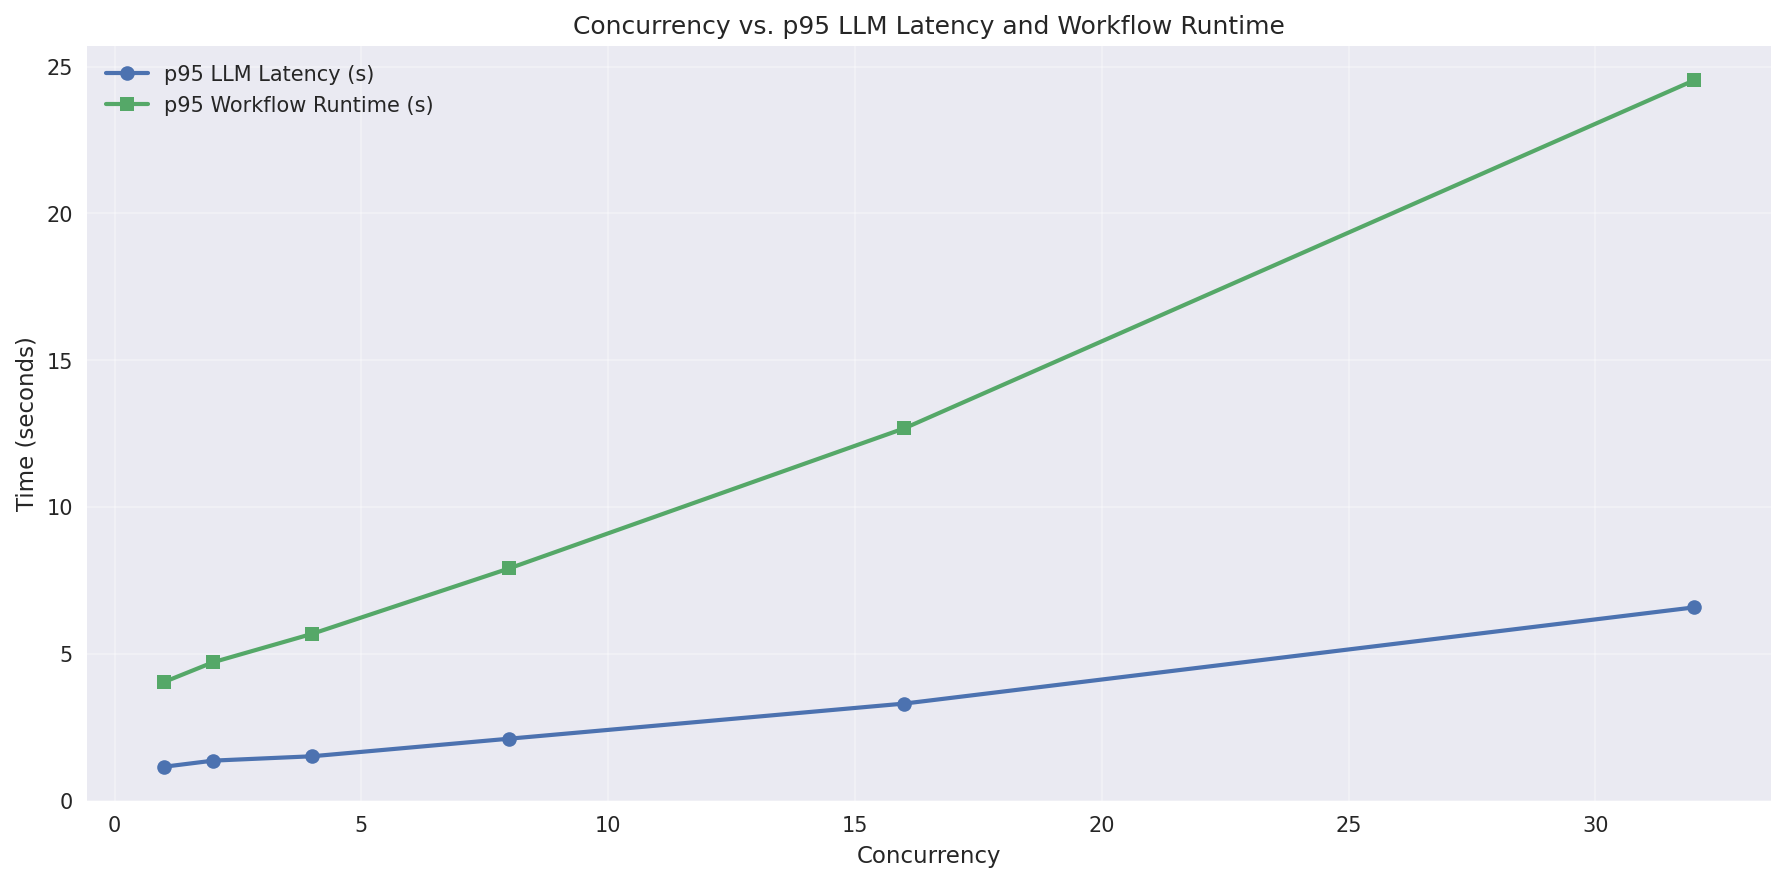

An enhanced analysis plot is also generated. This plot is described in more detail in the [Slope-based Estimation](#Slope-based-Estimation) section.

### JSON Output

The JSON file contains the per-concurrency metrics you can use for more analysis.
Sample output:
`calc_runner_output.json`:
```bash
{
  "gpu_estimates": {
    "gpu_estimate_by_wf_runtime": 76.61472307484419,
    "gpu_estimate_by_llm_latency": null
  },
  "per_concurrency_data": {
    "1": {
      "gpu_estimates": {
        "gpu_estimate_by_wf_runtime": 309.15830421447754,
        "gpu_estimate_by_llm_latency": null
      },
      "out_of_range_runs": {
        "num_items_greater_than_target_latency": 0,
        "num_items_greater_than_target_runtime": 0,
        "workflow_interrupted": false
      },
      >>>>>> SNIPPED <<<<<
    }
  }
}
```

The output is truncated for brevity. For more information, refer to the [CalcRunnerOutput](../../../src/nat/profiler/calc/data_models.py) Pydantic model.

## Interpreting the Results

The sizing calculator provides two GPU count estimates:
- `Estimated GPU count (Workflow Runtime)`: Estimated GPU count based on the target workflow runtime.
- `Estimated GPU count (LLM Latency)`: Estimated GPU count based on the target LLM latency.

You can use a maximum of the two estimates as the final GPU count to accommodate the target users.

**Sample output:**
```
Targets: LLM Latency ≤ 0.0s, Workflow Runtime ≤ 10.0s, Users = 100
Test parameters: GPUs = 8
Per concurrency results:
|   Concurrency |   p95 LLM Latency |   p95 WF Runtime |   Total Runtime |   Runtime OOR |   GPUs (WF Runtime, Rough) |
|---------------|-------------------|------------------|-----------------|---------------|----------------------------|
|             1 |           1.14981 |          4.03488 |         8.06977 |             0 |                   322.79   |
|             2 |           1.3591  |          4.71197 |         9.32298 |             0 |                   188.479  |
|             4 |           1.50682 |          5.67581 |        11.1683  |             0 |                   113.516  |
|             8 |           2.10668 |          7.90895 |        15.6193  |             0 |                    79.0895 |
|            16 |           3.30196 |         12.677   |        25.3173  |            32 |                            |
|            32 |           6.57847 |         24.5307  |        43.9806  |            64 |                            |

=== GPU ESTIMATES ===
Estimated GPU count (Workflow Runtime): 75.4
```

**Note:**

In addition to the slope based estimation, the calculator also provides a rough estimate of the GPU count required for the target user based on the data from each concurrency level. You can use this information to get a quick estimate of the GPU count required for the workflow but is not as accurate as the slope based estimation and is not recommended for production use.

### Slope-based Estimation

The sizing calculator uses a **slope-based estimation** approach to determine how your workflow’s performance scales with increasing concurrency. This method helps estimate the number of GPUs required to meet your target user load and response time.

**Analysis Plots**

The analysis plots, generated by the calculator, offer a visual representation of the concurrency vs. latency and concurrency vs. runtime. The trend line is a linear fit of the concurrency vs. time metrics. The slope of the trend line is used to estimate the GPU count required for the workflow.

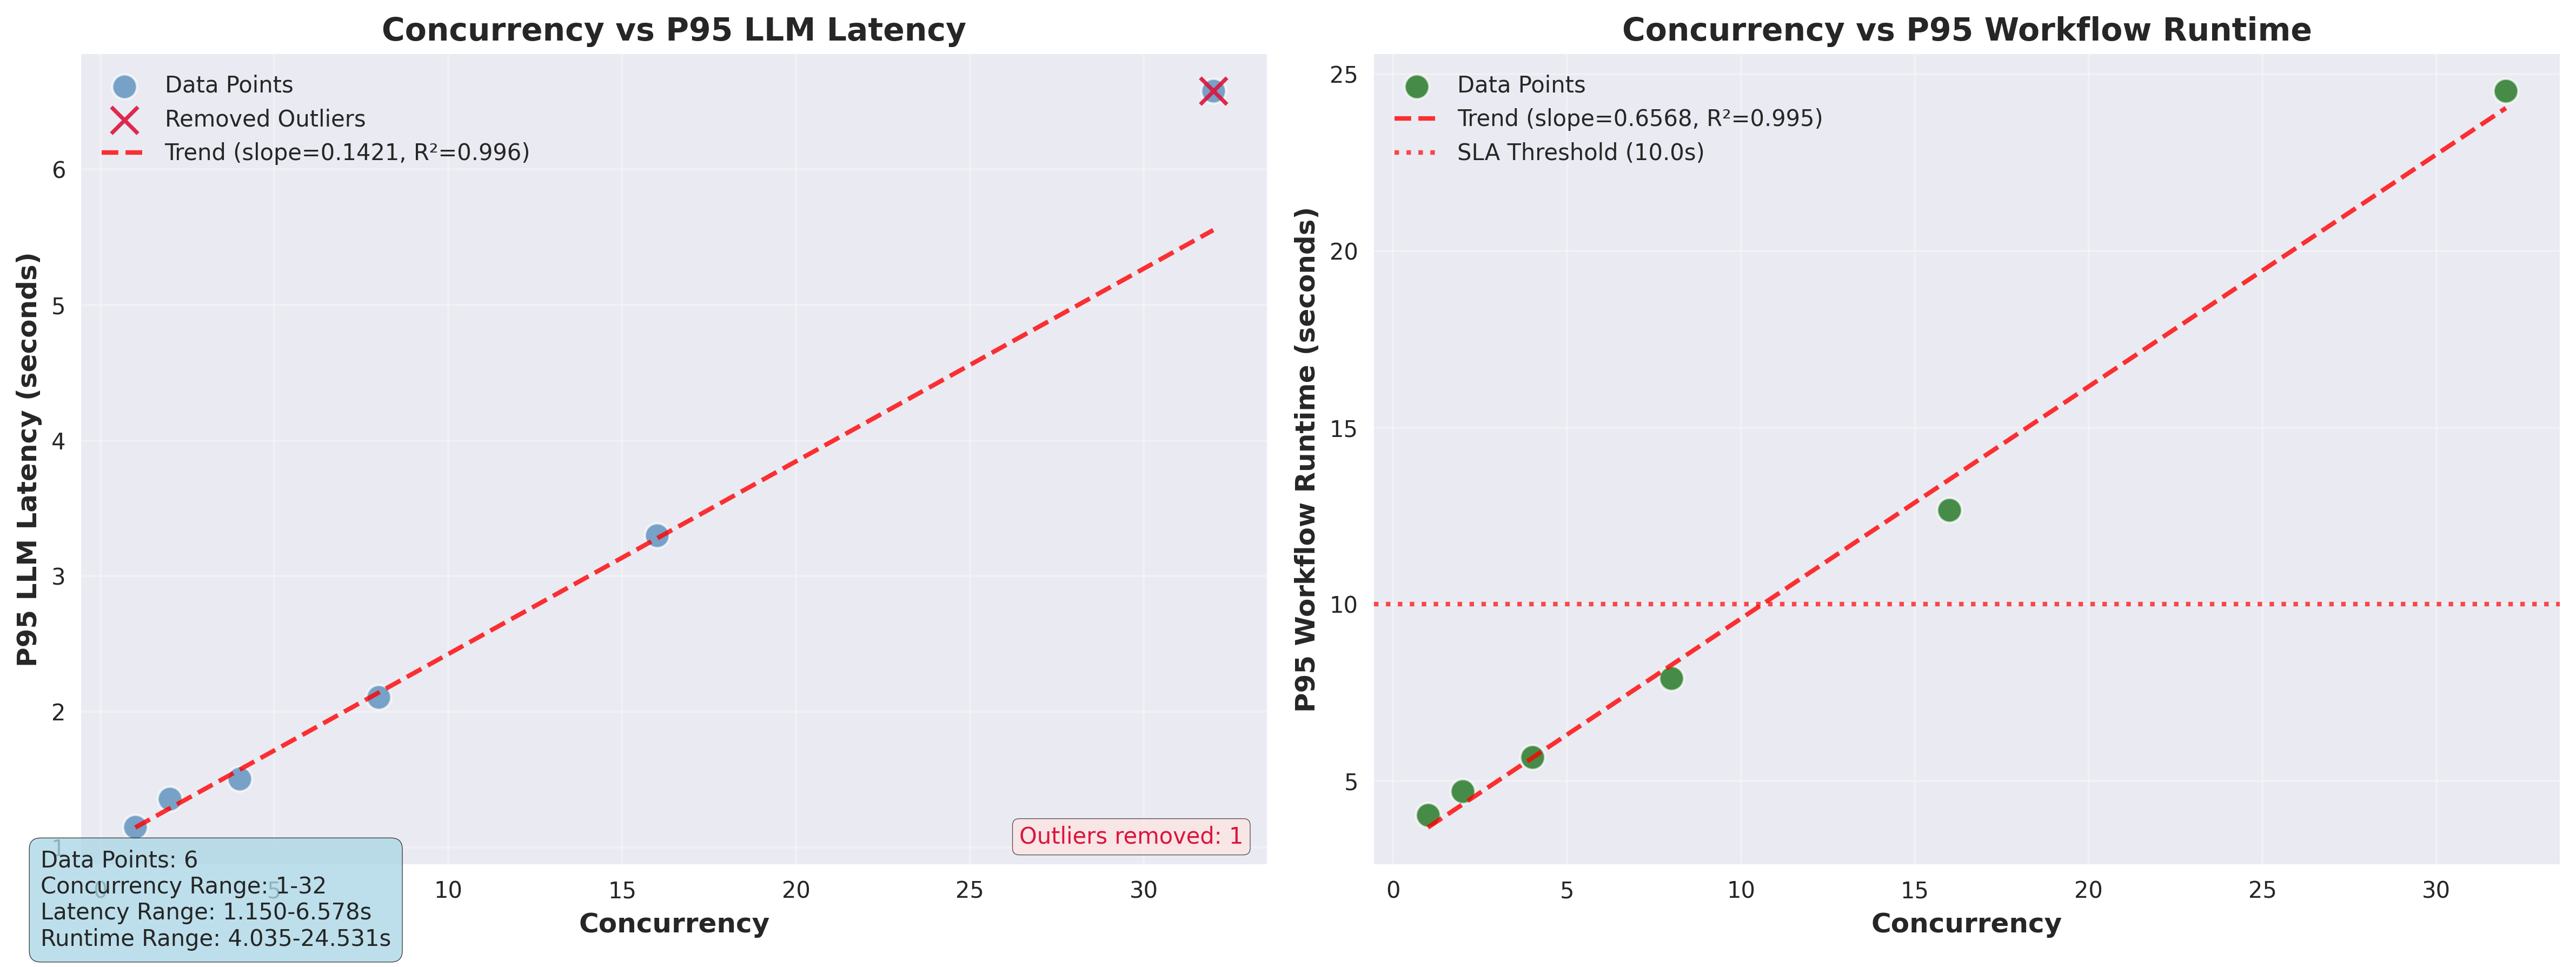

**Estimation Process**

To estimate the GPU count required for the workflow, the calculator performs the following steps:

1. **Linear Fit of Concurrency vs. Time Metrics**
   - The calculator runs your workflow at several different concurrency levels.
   - For each level, it measures key metrics such as p95 LLM latency and p95 workflow runtime.
   - It then fits a straight line (using least squares regression) to the data points, modeling how time metrics change as concurrency increases.

2. **Slope and Intercept**
   - The **slope** of the fitted line represents how much the time metric (latency or runtime) increases for each additional concurrent user. A slope of 1.0 means that the time metric increases perfectly linearly with the concurrency. A slope greater than 1.0 means that the time metric increases faster than linearly with the concurrency and optimization should be done to reduce the slope.
   - The **intercept** represents the baseline time metric when concurrency is zero (theoretical minimum). Note that this is a mathematical extrapolation and may not correspond to actual measurements at concurrency=0. It is indicative of the overhead of the workflow.

3. **R² Value**
   - The calculator computes the R² (coefficient of determination) to indicate how well the linear model fits your data. An R² value close to 1.0 means a good fit.
   - If the R² value is less than 0.7, the calculator will not use the linear fit to estimate the GPU count.

4. **Outlier Removal**
   - Outliers (data points that deviate significantly from the trend) are automatically detected and removed to ensure a robust fit using the `Interquartile Range` (IQR) method.
   - For datasets with fewer than 8 data points, outliers are detected using raw time metric values. For larger datasets, outliers are detected using residuals from the linear fit.

5. **Estimating Required Concurrency**
   - Using your target time metric (for example, target workflow runtime), the calculator determines the maximum concurrency that can be supported for the `test_gpu_count`, while still meeting the target time. This is the `calculated_concurrency` in the formula below.

6. **GPU Count Formula**
   - The required GPU count is estimated using the formula:
     ```
     calculated_concurrency = (target_time_metric - intercept) / slope
     gpu_estimate = (target_users / calculated_concurrency) * test_gpu_count
     ```
   - This formula scales your test results to your target user load, based on the observed scaling behavior.

**Example:**

Suppose your target workflow runtime is 10 seconds, the linear fit gives a slope of 0.6, and an intercept of 3.5. The calculator will compute the concurrency that achieves a 10s runtime:
  `(10 - 3.5) / 0.6 ≈ 10.83`
If you tested with 8 GPUs and want to support 100 users, the calculator will compute the amount of GPUs needed:
  `(100 / 10.83) * 8 ≈ 73.9 GPUs`

**Key Points:**
- The more concurrency levels you test, the more accurate the estimation.
- Outliers and failed runs are excluded from the fit.
- The calculator provides both workflow runtime-based and LLM latency-based GPU estimates (if both targets are specified).

## Handling Failed Workflows
Based on the test setup, you may meet failures as the concurrency value increases. When a workflow fails for an input, the pass stops for that particular concurrency value. The pass is tagged with a `workflow_interrupted` flag in the JSON output. Such concurrencies, with a `workflow_interrupted` flag set to `true`, are not included in the GPU estimate. This information is indicated in the summary table in an `Alerts` column.

The following is sample output with alerts:
```
Targets: LLM Latency ≤ 0.0s, Workflow Runtime ≤ 0.0s, Users = 0
Test parameters: GPUs = 0
Per concurrency results:
Alerts: !W = Workflow interrupted
| Alerts |   Concurrency |   p95 LLM Latency |   p95 WF Runtime |   Total Runtime |
|--------|---------------|-------------------|------------------|-----------------|
|        | 1             | 1.14981           | 4.03488          |         8.06977 |
|        | 2             | 1.3591            | 4.71197          |         9.32298 |
| !W     | 4             | 1.50682           | 5.67581          |         11.1683 |
|        | 8             | 2.10668           | 7.90895          |         15.6193 |
|        | 16            | 3.30196           | 12.677           |         25.3173 |
|        | 32            | 6.57847           | 24.5307          |         43.9806 |
```

In this example, the workflow failed at concurrency level 4 (indicated by `!W` in the Alerts column). The time metrics for concurrency 4 are not included in the GPU estimate as they are not reliable and may skew the linear fit used to estimate the GPU count.

## Alternative Workflows

### Using a Remote Workflow
By default, the calculator runs the workflow locally to gather metrics. You can use the `--endpoint` and `--endpoint_timeout` command line parameters to use a remote workflow for gathering metrics.

Start the remote workflow:
```bash
nat start fastapi --config_file=$CONFIG_FILE
```

Run the calculator using the remote endpoint:
```bash
nat sizing calc --config_file $CONFIG_FILE --calc_output_dir $CALC_OUTPUT_DIR --concurrencies 1,2,4,8,16,32 --num_passes 2 --endpoint http://localhost:8000
```
The configuration file used for running the calculator only needs to specify the `eval` section. The `workflow` section is not used by the calculator when running with a remote endpoint.

### Programmatic Usage
In addition to the command line interface, the sizing calculator can be used programmatically.

**Sample code:**
```python
import asyncio
from nat.profiler.calc.calc_runner import CalcRunner
from nat.profiler.calc.data_models import CalcRunnerConfig
from nat.profiler.calc.data_models import CalcRunnerOutput

async def run_calc():
    runner_config = CalcRunnerConfig(
        config_file="config.yml",
        output_dir=".tmp/calc/",
        concurrencies=[1, 2, 4, 8, 16, 32],
        num_passes=2,
        test_gpu_count=8,
        target_workflow_runtime=10,
        target_users=100,
    )
    runner = CalcRunner(runner_config)
    result: CalcRunnerOutput = await runner.run()
    # Access GPU estimates and per-concurrency metrics from result
    print(result.gpu_estimates)
    print(result.per_concurrency_data)

# Run the async calc function
asyncio.run(run_calc())
```

{py:class}`~nat.profiler.calc.data_models.CalcRunnerConfig` is a Pydantic model that contains the configuration for the calculator. It provides fine-grained control over the calculator's behavior.
{py:class}`~nat.profiler.calc.data_models.CalcRunnerOutput` is a Pydantic model that contains the per-concurrency metrics and the GPU count estimates.
For more information, refer to the [calculator data models](../../../src/nat/profiler/calc/data_models.py).

## Additional Resources

- **Repository**: [NVIDIA NeMo Agent Toolkit](https://github.com/NVIDIA/NeMo-Agent-Toolkit)
- **Documentation**: [Full Documentation](https://docs.nvidia.com/nemo/agent-toolkit/latest/index.html)
- **Get Started Guide**: [Getting Started](https://docs.nvidia.com/nemo/agent-toolkit/latest/quick-start/installing.html)
- **Examples**: Check the `examples/` directory in the cloned repository
- **Evaluation Guide**: [Evaluate with NeMo Agent Toolkit](https://docs.nvidia.com/nemo/agent-toolkit/latest/workflows/evaluate.html)
- **Troubleshooting**: [Common Issues](https://docs.nvidia.com/nemo/agent-toolkit/latest/troubleshooting.html)
